In [ ]:
%matplotlib inline

# REINFORCE on the CartPole Environment

This is an altered version of Jose Nieves Flores Maynez' notebook.

This tutorial shows how to use REINFORCE to train an RL agent on the CartPole-v0 task from the [OpenAI Gym](https://gym.openai.com/).

![cartpole](https://github.com/pytorch/tutorials/blob/main/_static/img/cartpole.gif?raw=true)

The Cartpole environment is a common simple example that is used often for simple RL examples.

In this environment, the task is to balance the pole that is attached to the cart, by moving the cart to either side.
The reward gets incremented for each step (for up to 200 steps) where the pole is not exceeding a set angle and the cart is not touching the sides of the line.
The environment provides four parameters that represent the state of the environment:
Position and velocity of the cart and angle and angular velocity of the pole (see [the documentation](https://gymnasium.farama.org/environments/classic_control/cart_pole/#observation-space)).
We will solve this by applying REINFORCE to our RL agent.


### Packages


First, let's import needed packages.

In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## Implementation
Since this algorithm relies on updating a function for each existing pair of state and action, environments that have a high state-space become problematic. This is because we can approximate better the actual value of a state-action pair as we visit it more often. However, if we have many states or many actions to take, we distribute our visits among more pairs and it takes much longer to converge to the actual true values. The CartPole environment gives us the position of the cart, its velocity, the angle of the pole and the velocity at the tip of the pole as descriptors of the state. However, all of these are continuous variables. To be able to solve this problem, we need to discretize these states since otherwise, it would take forever to get values for each of the possible combinations of each state, despite them being bounded. The solution is to group several values of each of the variables into the same “bucket” and treat them as similar states. The agent implemented for this problem uses 3, 3, 6, and 6 buckets respectively.

In [ ]:
"""
Base code taken from:
https://github.com/IsaacPatole/CartPole-v0-using-Q-learning-SARSA-and-DNN/blob/master/Qlearning_for_cartpole.py
"""

class CartPoleReinforceAgent():
    def __init__(self, buckets=(3, 3, 6, 6),
                 num_episodes=2000, min_lr=0.01,
                 discount=0.99, decay=25, discretize=False):
        self.buckets = buckets
        self.num_episodes = num_episodes
        self.min_lr = min_lr
        # self.min_epsilon = min_epsilon
        self.discount = discount
        self.decay = decay
        self.discretize = discretize

        self.env = gym.make('CartPole-v0')

        # Theta is added as with the same size as state (4 in our case)
        self.theta = np.random.rand(self.env.observation_space.shape[0])

        # [position, velocity, angle, angular velocity]
        self.upper_bounds = [self.env.observation_space.high[0], 0.5, self.env.observation_space.high[2], math.radians(50) / 1.]
        self.lower_bounds = [self.env.observation_space.low[0], -0.5, self.env.observation_space.low[2], -math.radians(50) / 1.]

        #
        self.steps = np.zeros(self.num_episodes)

    def discretize_state(self, obs):
        """
        Takes an observation of the environment and aliases it.
        By doing this, very similar observations can be treated
        as the same and it reduces the state space so that the
        Q-table can be smaller and more easily filled.

        Input:
        obs (tuple): Tuple containing 4 floats describing the current
                     state of the environment.

        Output:
        discretized (tuple): Tuple containing 4 non-negative integers smaller
                             than n where n is the number in the same position
                             in the buckets list.
        """
        if not self.discretize:
            return obs
        discretized = list()
        for i in range(len(obs)):
            scaling = ((obs[i] + abs(self.lower_bounds[i]))
                       / (self.upper_bounds[i] - self.lower_bounds[i]))
            new_obs = int(round((self.buckets[i] - 1) * scaling))
            new_obs = min(self.buckets[i] - 1, max(0, new_obs))
            discretized.append(new_obs)
        return tuple(discretized)

    def get_learning_rate(self, t):
        """Gets value for learning rate. It declines as we advance in episodes."""
        # Learning rate also declines as we add more episodes
        return max(self.min_lr, min(1., 1. - math.log10((t + 1) / self.decay)))

    def plot_learning(self):
        """
        Plots the number of steps at each episode and prints the
        amount of times that an episode was successfully completed.
        """
        sns.lineplot(data=self.steps)
        plt.xlabel("Episode")
        plt.ylabel("Steps")
        plt.show()
        t = 0
        for i in range(self.num_episodes):
            if self.steps[i] == 200:
                t+=1
        print(t, "episodes were successfully completed.")


    def run(self):
        """Runs an episode while displaying the cartpole environment."""
        self.env = gym.wrappers.Monitor(self.env,'cartpole')
        t = 0
        done = False
        current_state = self.discretize_state(self.env.reset())
        while not done:
                self.env.render()
                t = t+1
                action = self.choose_action(current_state)
                obs, reward, done, _ = self.env.step(action)
                new_state = self.discretize_state(obs)
                current_state = new_state

        return t

## Choosing an Action by it's theta values and the probabilities.
- The red part is **y**
- The blue part is the probability of a0 **pa0**


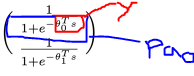


(see Week 3 Page 24)

In [ ]:
class CartPoleReinforceAgent(CartPoleReinforceAgent):
    def logistic_fn(self, state):
        logits = np.dot(self.theta, state)
        #print('Logits:', logits)
        return 1 / (1 + np.exp(-logits))

    def choose_action(self, current_state):
        return np.random.choice(self.env.action_space.n, p=self.get_probabilities(current_state))
    
    def get_probabilities(self, current_state):
        pa0 = self.logistic_fn(current_state)
        if pa0 < 0.1:
            pa0 = 0.1
        if pa0 > 0.9:
            pa0 = 0.9
        return [pa0, 1 - pa0]

## Calculate Estimated Return
The estimated return per step in episode looks like this:


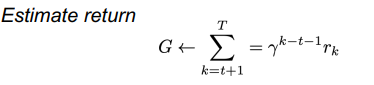

(see Week 3 Page 25)

that's what we need to implement in reverse to have an episode reward we can add as sum.

In [ ]:
class CartPoleReinforceAgent(CartPoleReinforceAgent):
    def calculate_estimated_returns(self, rewards):
        estimated_returns = []
        T = len(rewards)
        for t in range(T):
            estimated_return_t = 0
            for k in range(t+1, T):
                d = math.pow(self.discount, k - t - 1)
                estimated_return_t += d * rewards[k]
            estimated_returns.append(estimated_return_t)
        return estimated_returns
    
    def calculate_estimated_returns_v2(self, rewards):
        estimated_returns = []
        T = len(rewards)
        # Loop over each step in the episode in reverse
        for t in reversed(range(T)):
            estimated_return_t = 0 
            for k in range(t, T):
                estimated_return_t += (self.discount ** (k - t)) * rewards[k]
            estimated_returns.insert(0, estimated_return_t)
        return estimated_returns
    
    def calculate_estimated_returns_v3(self, rewards):
        G = 0
        T = len(rewards)
        estimated_returns = []
        for t in reversed(range(T)):
            G = G * self.discount + rewards[t]
            estimated_returns.insert(0, G)
        return estimated_returns

## Calculate the Policy Gradient
We have a logistic policy gradient which has to be calculated
The policy pi(a|s, theta) is in our case the `log_function` (see implementation)


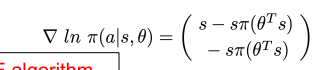


(see Week 3 Page 24)

In [ ]:
class CartPoleReinforceAgent(CartPoleReinforceAgent):
    def calculate_policy_gradient(self, state, action):
        probability = self.logistic_fn(state)
        #print('Action', action, 'with probability', probability)
        gradient = - np.array(state) * probability
        return gradient if action == 1 else (np.array(state) + gradient)

## Update Theta
Here the thetas need to be updated (gradient update)
- **alpha** --> `self.learning_rate`
- **theta^t** --> `np.pow(self.discount, t)`
- **G** --> `estimated_returns[t]`
- **delta_pi(a|s, theta)** --> `gradient[i]`


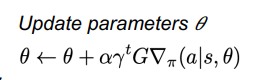


(see Week 3 Page 25)



In [ ]:
class CartPoleReinforceAgent(CartPoleReinforceAgent):
    def update_theta(self, states, actions, estimated_returns):
        for t in reversed(range(len(states))):
            #print('Action:', actions[t], 'State:', states[t], 'Theta:', self.theta)
            gradient = self.calculate_policy_gradient(states[t], actions[t])
            #print('Gradient', gradient)
            self.theta += self.learning_rate * np.power(self.discount, t) * estimated_returns[t] * gradient

In [ ]:
class CartPoleReinforceAgent(CartPoleReinforceAgent):
    def train(self):
        # Looping for each episode
        for e in range(self.num_episodes):
            # Initializes the state
            current_state = self.discretize_state(self.env.reset()[0])

            self.learning_rate = 0.002#self.get_learning_rate(e)
            done = False

            states = []
            actions = []
            rewards = []

            # Looping for each step
            while not done:
                self.steps[e] += 1
                # Choose A from S
                action = self.choose_action(current_state)
                # Take action
                obs, reward, done, _, _ = self.env.step(action)
                new_state = self.discretize_state(obs)
                # save states, actions and rewards
                # or is here only done to append all lists in one line.
                states.append(current_state) or actions.append(action) or rewards.append(reward)
                current_state = new_state
                #print('Action taken:', action, 'with probability:', self.get_probabilities(current_state)[action])
            estimated_returns = self.calculate_estimated_returns_v3(rewards)
            self.update_theta(states, actions, estimated_returns)
            print('#######################################################')
            print("Episode {}: Total Reward: {}".format(e + 1, sum(rewards)))
            #print('Estimated Return:', estimated_returns)
            #print('Thetas:', self.theta)
            print('#######################################################')
        print('Finished training!')

In [ ]:
def load_reinforce():
    agent = CartPoleReinforceAgent(discretize=False)
    agent.train()
    agent.plot_learning()

    return agent

agent = load_reinforce()